In [1]:
import earthaccess,csv
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.ndimage import median_filter

In [2]:
%pip install haversine
import haversine as hs   
from haversine import Unit

  Using cached haversine-2.8.1-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached haversine-2.8.1-py2.py3-none-any.whl (7.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

In [4]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 84


QUEUEING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/84 [00:00<?, ?it/s]

In [5]:
date_requested = '20240508'

ind = 0 
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind)
    ind += 1

23
24


In [6]:
ds1 = xr.open_dataset(edward_paths[23])
ds2 = xr.open_dataset(edward_paths[24])

In [7]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [8]:
ds1_masked = crop_dataset_by_lat_lon(ds1,latmin,latmax,lonmin,lonmax)
ds2_masked = crop_dataset_by_lat_lon(ds2,latmin,latmax,lonmin,lonmax)

In [9]:
# Quick velocities: need to change
xv = np.arange(287, 293, 0.008)
yv = np.arange(33,39, 0.008)
grid_x, grid_y = np.meshgrid(xv, yv)
ssh=ds1_masked.ssha_karin_2+ds1_masked.height_cor_xover
lats=ds1_masked.latitude
lons=ds1_masked.longitude
grid_ssh1 = griddata((lons.values.ravel(),lats.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')
ssh=ds2_masked.ssha_karin_2+ds2_masked.height_cor_xover
lats=ds2_masked.latitude
lons=ds2_masked.longitude
grid_ssh2 = griddata((lons.values.ravel(),lats.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')

In [10]:
def compute_geos_current(ssh,lat):
    """
    ssh: (m) Make sure this is first corrected with height_cor_xover from L2 data! 
    lat: degrees N
    """
    
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000,4000 # m i changed it to 4000 to match res? need to double check
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

In [11]:
#Calculate
ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)
ug2,vg2,geos_current2 = compute_geos_current(grid_ssh2,grid_y)

In [14]:
tspan = ("2024-05-08", "2024-05-08")
#bbox = (-58, 37.5, -52, 41) #howie
bbox = (-73, 35, -70, 37) #edward
# bbox=(-61, 34, -59, 39) #patrick
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)
paths = earthaccess.open(results) #'streaming' data

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'longitude'

In [16]:
datatree = open_datatree(paths[0])
datatree
dataset = xr.merge(datatree.to_dict().values())
dataset
chl_ds = dataset.set_coords(("longitude", "latitude"))
# chl_ds = xr.open_dataset(paths[0]) # should rename this with file extention .nc
lon_chl = chl_ds.variables['longitude'] 
lat_chl = chl_ds.variables['latitude'] 
chl = chl_ds.variables['chlor_a']

In [19]:
dataset = xr.open_dataset('/home/jovyan/GO-SWACE/moana_dataset_merged.nc')
lon = dataset['longitude'] 
lat = dataset['latitude'] 

# dataset = dataset.assign_coords(lat = lat, lon = lon) #Open data with xarray for 'slice plots'
# dataset = dataset.set_coords(("longitude", "latitude"))
pico=dataset["picoeuk_moana"] 
pro = dataset['prococcus_moana']
pico = dataset['picoeuk_moana'] 
syn = dataset['syncoccus_moana'] 

In [20]:
pro_grid = griddata((lon.values.ravel()+360,lat.values.ravel()), pro.values.ravel(), (grid_x, grid_y), method='linear')
pico_grid = griddata((lon.values.ravel()+360,lat.values.ravel()), pico.values.ravel(), (grid_x, grid_y), method='linear')
syn_grid = griddata((lon.values.ravel()+360,lat.values.ravel()), syn.values.ravel(), (grid_x, grid_y), method='linear')
chl_grid = griddata((lon_chl.values.ravel()+360,lat_chl.values.ravel()), chl.values.ravel(), (grid_x, grid_y), method='linear')

<Figure size 640x480 with 0 Axes>

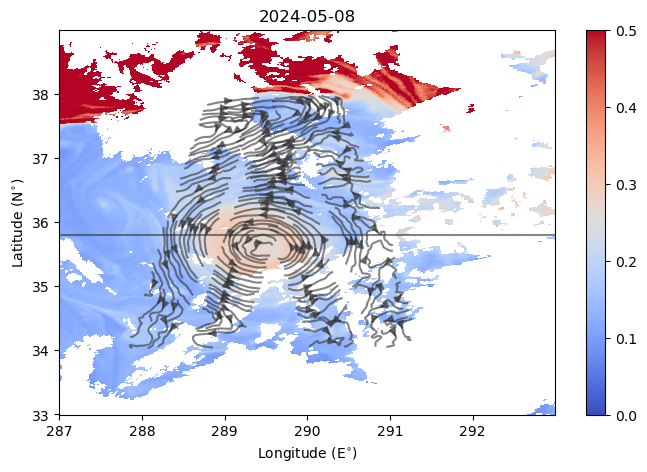

In [96]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,chl_grid,cmap='coolwarm',vmin=0,vmax=0.5)
cbar = plt.colorbar(plot,ax=ax)
plt.streamplot(grid_x,grid_y,ug1,vg1, density = 4, color = (0.2,0.2,0.2,0.6))
plt.streamplot(grid_x,grid_y,ug2,vg2, density = 4, color = (0.2,0.2,0.2,0.6))
plt.plot(grid_x[350,:],grid_y[350,:], color = (0.2,0.2,0.2,0.6)) #MOANA slice

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

In [25]:
#Select slice along SWOT
grid_x[200,:].max()

292.99199999998604

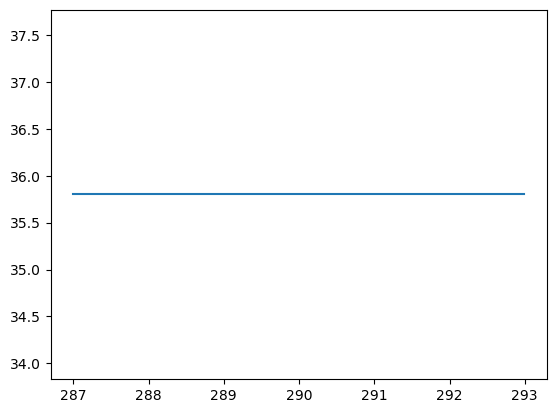

In [94]:
fig, ax = plt.subplots()

plt.plot(grid_x[350,:],grid_y[350,:]) #MOANA slice

In [40]:
grid_x[350,0]
grid_y[350,0]

287.0

In [97]:
loc1=(grid_y[350,0],grid_x[350,0]-360) #"origin"

alongtrack=[]

for idx in np.arange(0,len(grid_x[350,:])):
    loc2=(grid_y[350,idx],grid_x[350,idx]-360) 
    result=hs.haversine(loc1,loc2,unit=Unit.KILOMETERS)
    alongtrack=np.append(alongtrack,result)

In [ ]:
#define a line of latitudes and longitudes and extract data along that line. or sample to same grid

In [98]:
np.shape(alongtrack)

(750,)

In [52]:
np.shape(pico_grid[350,:])

(750,)

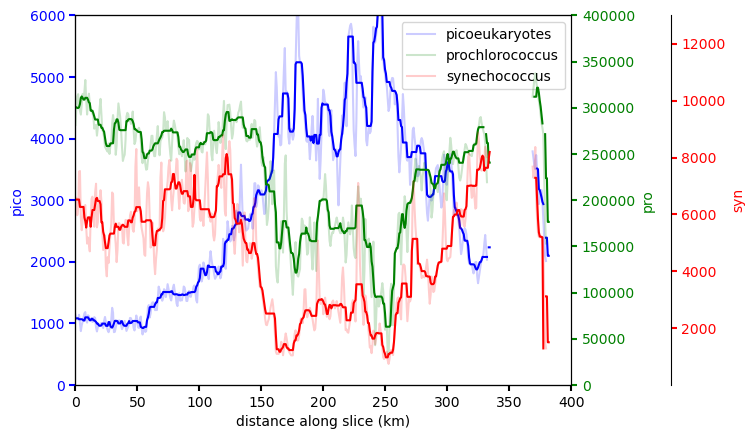

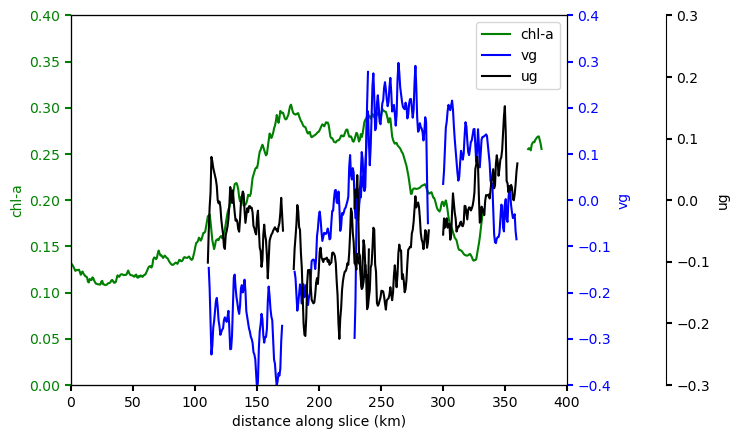

In [110]:
fig, ax = plt.subplots()
# fig, (ax, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,5))

fig.subplots_adjust(right=0.9)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot(alongtrack,pico_grid[350,:], "b-", label="picoeukaryotes",alpha=0.2)
ax.plot(alongtrack,median_filter(pico_grid[350,:],10), "b-", label="picoeukaryotes")
p2, = twin1.plot(alongtrack,pro_grid[350,:], "g-", label="prochlorococcus",alpha=0.2)
twin1.plot(alongtrack,median_filter(pro_grid[350,:],10), "g-", label="prochlorococcus")
p3, = twin2.plot(alongtrack,syn_grid[350,:], "r-", label="synechococcus",alpha=0.2)
twin2.plot(alongtrack,median_filter(syn_grid[350,:],10), "r-", label="synechococcus")

ax.set_xlim(0,400)
ax.set_ylim(0,6000)
twin1.set_ylim(0, 400000)
twin1.set_xlim(0,400)
twin2.set_ylim(1, 13000)
twin2.set_xlim(0,400)

ax.set_xlabel("distance along slice (km)")
ax.set_ylabel("pico")
twin1.set_ylabel("pro")
twin2.set_ylabel("syn")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()

fig, ax = plt.subplots()
# fig, (ax, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,5))

fig.subplots_adjust(right=0.9)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot(alongtrack,chl_grid[350,:], "g-", label="chl-a")
# ax.plot(alongtrack,median_filter(chl_grid[350,:],10), "g-", label="chl-a")

p2, = twin1.plot(alongtrack,vg1[350,:], "b-", label="vg")#,alpha=0.2)
# twin1.plot(alongtrack,median_filter(vg1[350,:],20), "b-", label="vg")
twin1.plot(alongtrack,vg2[350,:], "b-", label="vg")
# twin1.plot(alongtrack,median_filter(vg2[350,:],20), "b-", label="vg")

p3, = twin2.plot(alongtrack,ug1[350,:], "k-", label="ug")#,alpha=0.2)
# twin2.plot(alongtrack,median_filter(ug1[350,:],20), "k-", label="ug")
twin2.plot(alongtrack,ug2[350,:], "k-", label="ug")
# twin2.plot(alongtrack,median_filter(ug2[350,:],20), "k-", label="ug")


ax.set_xlim(0,400)
ax.set_ylim(0,0.4)
twin1.set_ylim(-0.4,0.4)
twin1.set_xlim(0,400)
twin2.set_ylim(-0.3,0.3)
twin2.set_xlim(0,400)

ax.set_xlabel("distance along slice (km)")
twin2.set_ylabel("ug")
twin1.set_ylabel("vg")
ax.set_ylabel("chl-a")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()

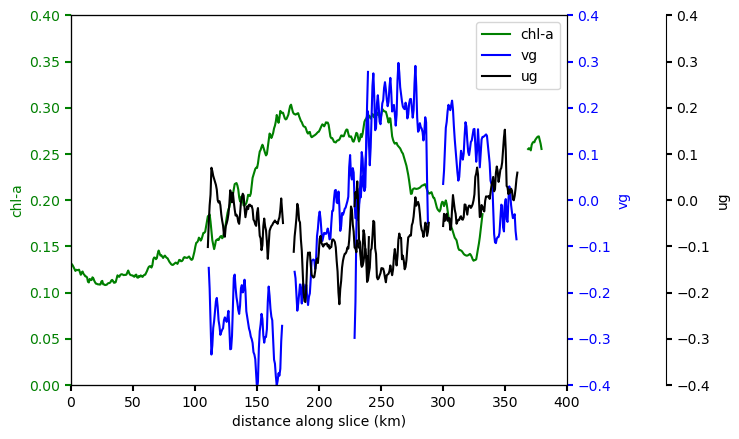